# Get all imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from mpl_toolkits import mplot3d
from matplotlib import cm
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc
from sklearn.metrics import pairwise_distances
from scipy.stats import wilcoxon, mannwhitneyu
from sklearn.preprocessing import StandardScaler
import copy

# Load the data and perform basic pre-processing

In [2]:
# Load the data
data = pd.read_csv("../data/input_data.csv")
# This column is not important
data = data.drop(["Unnamed: 0"], axis=1)
# Read the oem data
data.head(4)

,FEC_HORA_INI,NOM_ELEMENTO,COD_ELEMENTO,NOM_INSTALACION,BIN_YAW,Sum_Of_Avg_W_In_Bin,Yaw_Bin_Rank
0,2020-10-01,002,11267.0,BLUE CREEK,"(26, Infinito]",2819.48,1.0
1,2020-10-01,003,11268.0,BLUE CREEK,"(26, Infinito]",2991.07,1.0
2,2020-10-01,004,11269.0,BLUE CREEK,"(26, Infinito]",2932.53,1.0
3,2020-10-01,005,11270.0,BLUE CREEK,"(26, Infinito]",2937.90,1.0


In [2]:
# Load the data
data = pd.read_csv("../data/input_data.csv")
# This column is not important
data = data.drop(["Unnamed: 0"], axis=1)
# Read the oem data
oem_data = pd.read_csv("../data/oem_data.csv")
# This column is not important
oem_data = oem_data.drop(["Unnamed: 0"], axis=1)
# Merge turbine model with current data
data = data.merge(oem_data[["Model","COD_ELEMENTO"]], how="left", on="COD_ELEMENTO")
# Let's check out the data
display(data)

,FEC_HORA_INI,NOM_ELEMENTO,COD_ELEMENTO,NOM_INSTALACION,BIN_YAW,Sum_Of_Avg_W_In_Bin,Yaw_Bin_Rank,Model
0,2020-10-01,002,11267.0,BLUE CREEK,"(26, Infinito]",2819.48,1.0,G90-LM-2.0 MW
1,2020-10-01,003,11268.0,BLUE CREEK,"(26, Infinito]",2991.07,1.0,G90-LM-2.0 MW
2,2020-10-01,004,11269.0,BLUE CREEK,"(26, Infinito]",2932.53,1.0,G90-LM-2.0 MW
3,2020-10-01,005,11270.0,BLUE CREEK,"(26, Infinito]",2937.90,1.0,G90-LM-2.0 MW
4,2020-10-01,007,11271.0,BLUE CREEK,"(26, Infinito]",2915.70,1.0,G90-LM-2.0 MW
...,...,...,...,...,...,...,...,...
57259,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(14, 18]",2718.96,11.0,S88-2.1 MW
57260,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(-Infinito, -26]",2693.18,12.0,S88-2.1 MW
57261,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(26, Infinito]",2644.22,13.0,S88-2.1 MW
57262,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(18, 22]",2525.33,14.0,S88-2.1 MW


# Defining a scoring function which provides quantifies alert severity

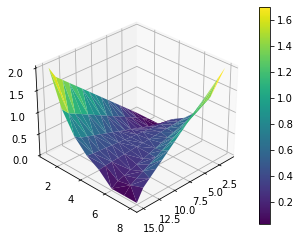

In [3]:
num_ranks = 15
values = [-50, -30, -10, 1, 1.5, 2, 2.5, 3]
dampening_factor = 0.1
severity_score = [list() for i in range(num_ranks)]

# We will first generate all severity scores for only the positive bins
# Generate alert severity for rank=1
for i in values:
    severity_score[0].append(dampening_factor*np.exp(i))

# Generate alert severity for rank=1
severity_score[-1] = sorted(severity_score[0], reverse=True)

# Now generate intermediate severity scores for remaining ranks
delta = [abs((severity_score[0][j] - severity_score[-1][j]) / num_ranks) for j in range(len(values))]
for i in range(1, num_ranks-1):
    # First add till half of bins
    mid = math.ceil(len(values)/2)
    for j in range(mid):
        severity_score[i].append(severity_score[i-1][j]+delta[j])
    for j in range(mid, len(values)):
        severity_score[i].append(severity_score[i-1][j]-delta[j])

        
# Now plot the severity scores for different ranks
# %matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

scoring_function_3d = list()
for i in range(num_ranks):
    for j in range(len(values)):
        scoring_function_3d.append([i+1, j+1, severity_score[i][j]])
scoring_function_3d = np.array(scoring_function_3d)

surf = ax.plot_trisurf(scoring_function_3d[:,0], scoring_function_3d[:,1], scoring_function_3d[:,2], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(surf)
ax.view_init(30, 45)
plt.show()

# Generate a new column containing severity score for each bin+rank

In [4]:
tmp = list()
X1, X2 = data["BIN_YAW"].values, data["Yaw_Bin_Rank"].values
for i in range(len(X1)):
    if "26" in X1[i] and "Infinito" in X1[i]:
        tmp.append(severity_score[int(X2[i])-1][-1])
    elif "26" in X1[i] and "22" in X1[i]:
        tmp.append(severity_score[int(X2[i])-1][-2])
    elif "22" in X1[i] and "18" in X1[i]:
        tmp.append(severity_score[int(X2[i])-1][-3])
    elif "18" in X1[i] and "14" in X1[i]:
        tmp.append(severity_score[int(X2[i])-1][-4])
    elif "14" in X1[i] and "10" in X1[i]:
        tmp.append(severity_score[int(X2[i])-1][-5])
    elif "10" in X1[i] and "6" in X1[i]:
        tmp.append(severity_score[int(X2[i])-1][-6])
    elif "6" in X1[i] and "2" in X1[i]:
        tmp.append(severity_score[int(X2[i])-1][-7])
    else:
        tmp.append(severity_score[int(X2[i])-1][0])
data["severity_scores"] = tmp
display(data)

,FEC_HORA_INI,NOM_ELEMENTO,COD_ELEMENTO,NOM_INSTALACION,BIN_YAW,Sum_Of_Avg_W_In_Bin,Yaw_Bin_Rank,Model,severity_scores
0,2020-10-01,002,11267.0,BLUE CREEK,"(26, Infinito]",2819.48,1.0,G90-LM-2.0 MW,2.008554e+00
1,2020-10-01,003,11268.0,BLUE CREEK,"(26, Infinito]",2991.07,1.0,G90-LM-2.0 MW,2.008554e+00
2,2020-10-01,004,11269.0,BLUE CREEK,"(26, Infinito]",2932.53,1.0,G90-LM-2.0 MW,2.008554e+00
3,2020-10-01,005,11270.0,BLUE CREEK,"(26, Infinito]",2937.90,1.0,G90-LM-2.0 MW,2.008554e+00
4,2020-10-01,007,11271.0,BLUE CREEK,"(26, Infinito]",2915.70,1.0,G90-LM-2.0 MW,2.008554e+00
...,...,...,...,...,...,...,...,...,...
57259,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(14, 18]",2718.96,11.0,S88-2.1 MW,3.306084e-01
57260,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(-Infinito, -26]",2693.18,12.0,S88-2.1 MW,5.356143e-01
57261,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(26, Infinito]",2644.22,13.0,S88-2.1 MW,4.017107e-01
57262,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(18, 22]",2525.33,14.0,S88-2.1 MW,9.852468e-02


# Plot alert severity for each farm

In [ ]:
# All of the wind farms
wind_farms = data["NOM_INSTALACION"].unique()
# The count of each yaw_bin for each farm
wind_farm_yaw_severity = data.groupby(["NOM_INSTALACION"])["severity_scores"].sum()
wind_farm_yaw_bin_num = data.groupby(["NOM_INSTALACION"])["BIN_YAW"].unique()
total_turbines = data.groupby(["NOM_INSTALACION"])["COD_ELEMENTO"].nunique()
count = data.groupby(["NOM_INSTALACION"])["severity_scores"].count()


# farm_alert_severity is a list of tuples containing farm and corresponding severity score
farm_alert_severity, erroneous_farms = list(), list()
for farm in wind_farms:
    if len(wind_farm_yaw_bin_num[farm]) > 1:
        farm_alert_severity.append([farm, wind_farm_yaw_severity[farm]/count[farm]])
    else:
        erroneous_farms.append(farm)
print("% of farms having erroneous data: ", (len(erroneous_farms)/len(wind_farms))*100)

# Sort the farms according to their corresponding severity in descending order
farm_alert_severity.sort(key=lambda x: x[1], reverse=True)

# Now plot the results
plt.figure(figsize=(8, 35), dpi=200, facecolor='w', edgecolor='k')
plot = sns.barplot([j for i, j in farm_alert_severity], [i for i, j in farm_alert_severity])
plot.set_yticklabels(plt.yticks()[1], size = 6)
sns.despine()
plt.xlabel("Alert Severity")
plt.ylabel("Farms")
plt.title("Wind Farm Alert Severity Level")
# plt.show()
plt.savefig("Normalized.png", dpi=400)

# Save in csv
fp = open("farm_alert_severity.csv", "w")
fp.write("Wind Farm,Severity Score\n")
for i in range(len(farm_alert_severity)):
    fp.write(farm_alert_severity[i][0]+","+str(farm_alert_severity[i][1])+"\n")
fp.close()
    

# Plot alert severity for each turbine model

In [ ]:
# All of the wind turbine models
turbine_models = data["Model"].unique()
# The count of each yaw_bin for each model
turbine_model_yaw_severity = data.groupby(["Model"])["severity_scores"].sum()
turbine_model_yaw_bin_num = data.groupby(["Model"])["BIN_YAW"].unique()
count = data.groupby(["Model"])["severity_scores"].count()


# turbine_model_alert_severity is a list of tuples containing turbine model and corresponding severity score
turbine_model_alert_severity = list()
for model in turbine_models:
    turbine_model_alert_severity.append([model, turbine_model_yaw_severity[model]/count[model]])

# Sort the turbine models according to their corresponding severity in descending order
turbine_model_alert_severity.sort(key=lambda x: x[1], reverse=True)

# Now plot the results
plt.figure(figsize=(8, 10), dpi=200, facecolor='w', edgecolor='k')
plot = sns.barplot([j for i, j in turbine_model_alert_severity], [i for i, j in turbine_model_alert_severity])
plot.set_yticklabels(plt.yticks()[1], size = 6)
sns.despine()
plt.xlabel("Alert Severity")
plt.ylabel("Turbine Models")
plt.title("Turbine Model Alert Severity Level")
plt.show()

# Save in csv
fp = open("turbine_model_alert_severity.csv", "w")
fp.write("Turbine,Severity Score\n")
for i in range(len(turbine_model_alert_severity)):
    fp.write(turbine_model_alert_severity[i][0]+","+str(turbine_model_alert_severity[i][1])+"\n")
fp.close()

# Plot alert severity of each farm for every turbine model

In [ ]:
for i in data.groupby(["Model"]):
    new_data = i[1]
    turbine_model = i[0].replace("/", "_")
    
    # Create a folder for this turbine model
    try:
        os.mkdir("../data/"+turbine_model)
    except:
        pass

    # All of the wind farms
    wind_farms = new_data["NOM_INSTALACION"].unique()
    # The count of each yaw_bin for each farm
    wind_farm_yaw_severity = new_data.groupby(["NOM_INSTALACION"])["severity_scores"].sum()
    wind_farm_yaw_bin_num = new_data.groupby(["NOM_INSTALACION"])["BIN_YAW"].unique()
    total_turbines = new_data.groupby(["NOM_INSTALACION"])["COD_ELEMENTO"].nunique()
    count = new_data.groupby(["NOM_INSTALACION"])["severity_scores"].count()


    # farm_alert_severity is a list of tuples containing farm and corresponding severity score
    farm_alert_severity, erroneous_farms = list(), list()
    for farm in wind_farms:
        if len(wind_farm_yaw_bin_num[farm]) > 1:
            farm_alert_severity.append([farm, wind_farm_yaw_severity[farm]/count[farm]])
        else:
            erroneous_farms.append(farm)
    print(turbine_model+" having % of farms having erroneous data: ", (len(erroneous_farms)/len(wind_farms))*100)
    
    # Some farms have no data at all. These cause errors when plotting
    try:
        # Sort the farms according to their corresponding severity in descending order
        farm_alert_severity.sort(key=lambda x: x[1], reverse=True)

        # Now plot the results
        if len(wind_farms) < 10:
            plt.figure(figsize=(8, 5), dpi=200, facecolor='w', edgecolor='k')
        elif len(wind_farms) < 20:
            plt.figure(figsize=(8, 8), dpi=200, facecolor='w', edgecolor='k')
        else:
            plt.figure(figsize=(8, 15), dpi=200, facecolor='w', edgecolor='k')
        plot = sns.barplot([j for i, j in farm_alert_severity], [i for i, j in farm_alert_severity])
        plot.set_yticklabels(plt.yticks()[1], size = 6)
        sns.despine()
        plt.xlabel("Alert Severity")
        plt.ylabel("Farms")
        plt.title("Wind Farm Alert Severity Level for "+turbine_model)
        plt.savefig("../data/"+turbine_model+"/"+turbine_model+"_wind_farm_normalized.png", dpi=400)

        # Save in csv
        fp = open("../data/"+turbine_model+"/"+turbine_model+"_farm_alert_severity.csv", "w")
        fp.write("Wind Farm,Severity Score\n")
        for i in range(len(farm_alert_severity)):
            fp.write(farm_alert_severity[i][0]+","+str(farm_alert_severity[i][1])+"\n")
        fp.close()
    except:
        pass
    

# Important Utility Functions

In [7]:
# This function removes outliers based on density
# which is calculated by maximum distance between two samples to be considered as neighbours and minimum number of neighbours
def outlier_removal(X, Y, max_distance, min_neigh):
    data = np.stack((X, Y), axis=1)
    distances = np.sort(pairwise_distances(data), axis=1)
    indices_to_keep = list()
    for i in range(len(data)):
        if sum([1 if distances[i,j] < max_distance else 0 for j in range(1, min_neigh+1)]) == min_neigh:
            indices_to_keep.append(i)
    return data[indices_to_keep,0], data[indices_to_keep,1]


# This function takes in the X-axis values and converts them into nth polynomial equations
def convert_to_dataset(data, poly=1):
    new_data = np.zeros((len(data), poly))
    for i in range(len(data)):
        for j in range(1, poly+1):
            new_data[i,j-1] = data[i]**j
    return new_data

In [3]:
df = data[data["NOM_INSTALACION"] == 'VIEIRO']
df.head()

,FEC_HORA_INI,NOM_ELEMENTO,COD_ELEMENTO,NOM_INSTALACION,BIN_YAW,Sum_Of_Avg_W_In_Bin,Yaw_Bin_Rank
3826,2020-10-01,A01,5426.0,VIEIRO,"(26, Infinito]",1000.08,1.0
6517,2020-10-01,A02,5427.0,VIEIRO,"(26, Infinito]",592.42,1.0
7914,2020-10-01,A03,5428.0,VIEIRO,"(26, Infinito]",1111.00,1.0
9176,2020-10-01,A04,5429.0,VIEIRO,"(26, Infinito]",985.01,1.0
10347,2020-10-01,A05,5430.0,VIEIRO,"(26, Infinito]",1018.60,1.0


# Load Power data, preprocess and convert into usable format

In [5]:
# Load Power data
power_data = pd.read_csv("../data/VIEIRO.csv")
# This column is not important
power_data = power_data.drop(["Unnamed: 0"], axis=1)
# Since there are a lot of rows with NAN values, we therefore remove them
power_data = power_data.dropna()

# Get the indication of whether current value is power or wind_speed or....
power_data["function_type"] = [i.split(".")[-1] for i in power_data["Prefix"].values]

# Generate a list of required info. This is the precursor to the processed dataframe
new_power_data = list()
for i in tqdm(power_data.groupby(["__utctime", "farm", "Turbine_id"])):
    df = i[1]
    try:
        tmp_power = df[df["function_type"] == "W"]["value"].values[0]
    except:
        tmp_power = np.nan
    try:
        tmp_wind_dir = df[df["function_type"] == "WdDir"]["value"].values[0]
    except:
        tmp_wind_dir = np.nan
    try:
        tmp_wind_speed = df[df["function_type"] == "WdSpd"]["value"].values[0]
    except:
        tmp_wind_speed = np.nan
    try:
        tmp_pitch = df[df["function_type"] == "PtAngValBl1"]["value"].values[0]
    except:
        try:
            tmp_pitch = df[df["function_type"] == "PtAngSpBl1"]["value"].values[0]
        except:
            tmp_pitch = np.nan
    site = df.iloc[0]["farm"]
    turbine_id = df.iloc[0]["Turbine_id"]
    new_power_data.append([site, turbine_id, tmp_power, tmp_wind_dir, tmp_wind_speed, tmp_pitch])

# Use the list to generate a new, processed dataframe
power_data = pd.DataFrame(data=new_power_data, columns=["farm", "turbine_id", "power", "wind_dir", "wind_speed", "pitch"])
# Since there could be rows with NAN values, we therefore remove them
power_data = power_data.dropna()

# Now find a fixed range of wind speed for comparing different turbines.
# This is step is important without which turbines with more reading will get better AUC scores
min_power_speed = max(power_data.groupby(["turbine_id"])["wind_speed"].min().values)
max_power_speed = min(power_data.groupby(["turbine_id"])["wind_speed"].max().values)

# Now remove all rows that are not within given range of wind speed
power_data = power_data.drop(power_data[(power_data["wind_speed"] < min_power_speed) | (power_data["wind_speed"] > max_power_speed)].index)

# Finally, let's check out the data
display(power_data)

  0%|          | 0/84316 [00:00<?, ?it/s]

,farm,turbine_id,power,wind_dir,wind_speed,pitch
0,VIEIR,TA01,86.757039,47.680214,5.535425,0.785276
1,VIEIR,TA02,121.225223,49.094601,7.312436,-0.458122
2,VIEIR,TA03,-0.800000,36.023698,5.401157,87.099998
3,VIEIR,TA04,85.977516,51.894324,5.467811,0.354219
4,VIEIR,TA05,24.998042,52.034992,4.151002,1.500000
...,...,...,...,...,...,...
84311,VIEIR,TA15,319.201986,50.340366,7.668306,0.084106
84312,VIEIR,TA16,210.057916,50.880527,6.624937,0.232185
84313,VIEIR,TA17,227.993278,51.160148,6.417640,0.516118
84314,VIEIR,TA18,217.292427,52.461778,7.183612,-0.115306


# 1. Wind speed vs Power

### 1.1 Remove outliers and apply regression to get the Area Under the Curve (AUC) metric for each turbine

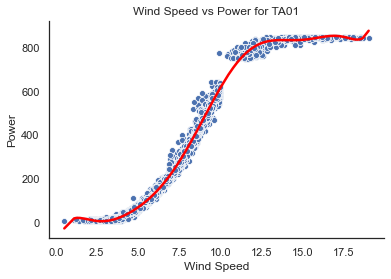

Area under the curve for TA01 :  8947.728229057662





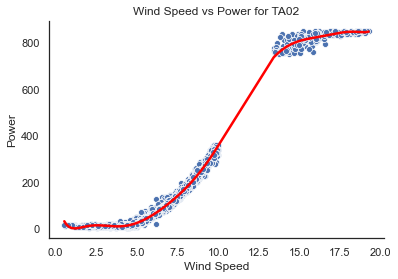

Area under the curve for TA02 :  7488.313363334415





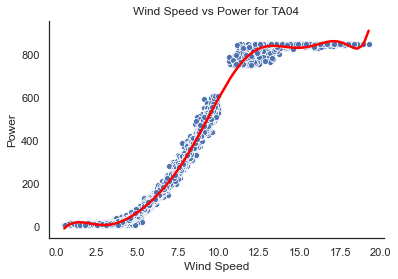

Area under the curve for TA04 :  9064.333094656295





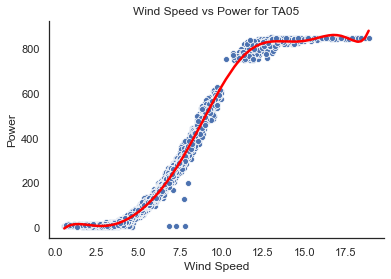

Area under the curve for TA05 :  8923.173390216318





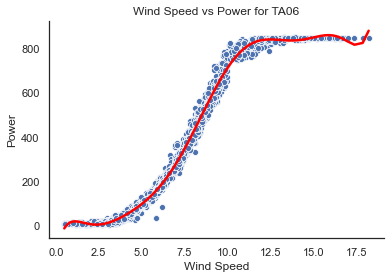

Area under the curve for TA06 :  8816.566780324187





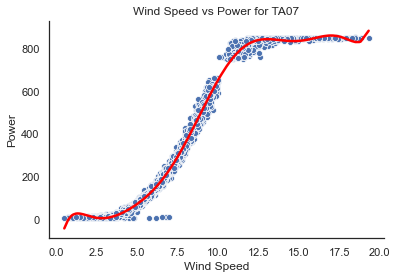

Area under the curve for TA07 :  9373.741781301742





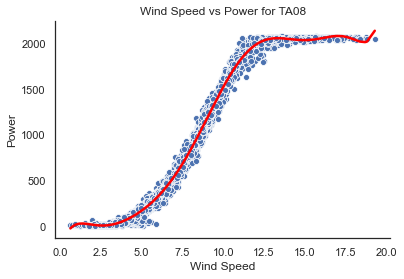

Area under the curve for TA08 :  22465.082011603565





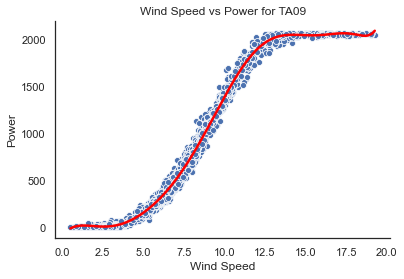

Area under the curve for TA09 :  21743.593858723747





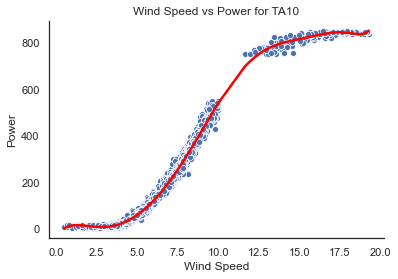

Area under the curve for TA10 :  8630.458063647899





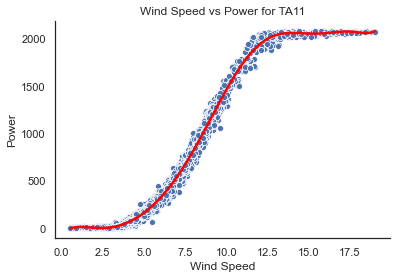

Area under the curve for TA11 :  21651.352622106384





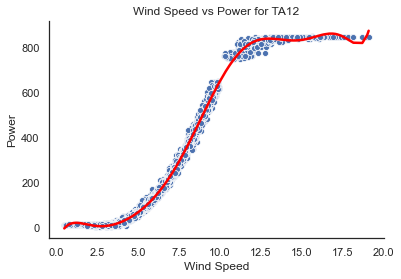

Area under the curve for TA12 :  9160.205719468597





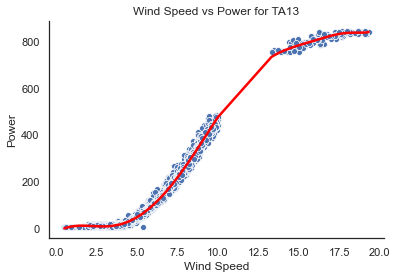

Area under the curve for TA13 :  8070.455915142061





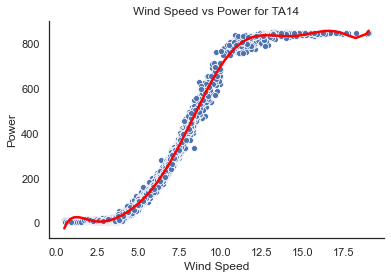

Area under the curve for TA14 :  9394.790052349746





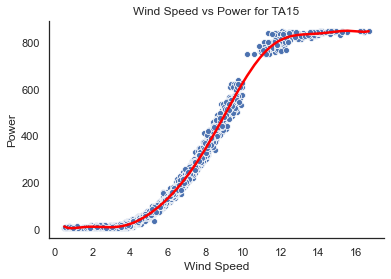

Area under the curve for TA15 :  7017.12400052232





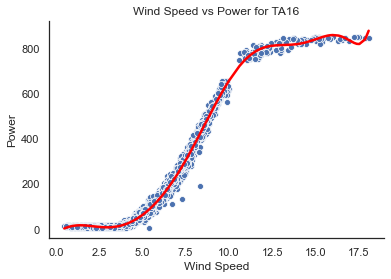

Area under the curve for TA16 :  8262.574431119116





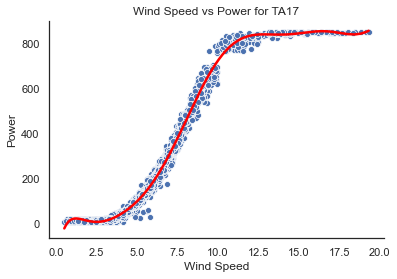

Area under the curve for TA17 :  9847.639730443925





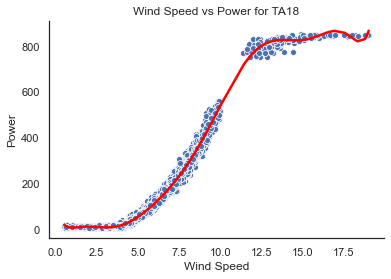

Area under the curve for TA18 :  8528.637544409303





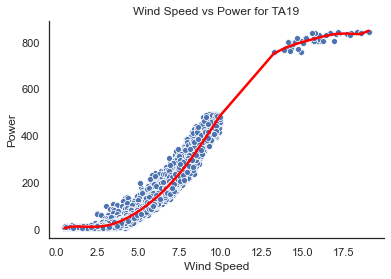

Area under the curve for TA19 :  8080.144229231371





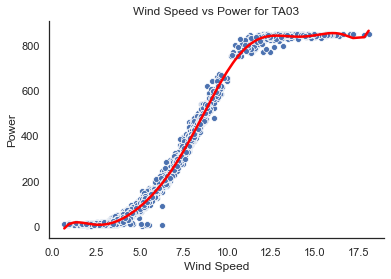

Area under the curve for TA03 :  8563.12164057461





In [8]:
# Remove rows that have less than 5 units of power because they are noise
new_power_data = power_data.drop(power_data[power_data["power"] <= 5].index)
# Remove rows that have less than 750 units of power when wind_speed is greater than 10 because they are noise
new_power_data = new_power_data.drop(new_power_data[(new_power_data["power"] <= 750) & (new_power_data["wind_speed"] >=10)].index)

# Add turbine ids that you want here
turbine_ids = new_power_data["turbine_id"].unique()
# Different turbines should be given different hyperparameter values for outlier removal
outlier_hyperparams_for_turbines = {"TE004": (2,3),
                                   "TE005": (2,3),
                                   "TE006": (3,3),
                                   "TE007": (3,3),
                                   "TE003": (3,3),
                                   "TG005": (12,3),
                                   "TG006": (8,3),
                                   "TL002": (6,2),
                                   "TL003": (12,3),
                                   "TL004": (6,2)}
# Save the regression based predictions into an array
turbine_pred_power = [list() for i in range(len(turbine_ids))]
turbine_auc = list()
turbine_dict = dict()

for index, turbine_id in enumerate(turbine_ids):
    # Get power values
    power = new_power_data[new_power_data["turbine_id"] == turbine_id]["power"].values
    # Get corresponding wind speed values
    wind_speed = new_power_data[new_power_data["turbine_id"] == turbine_id]["wind_speed"].values
    
    # Set default hyper-parameters for outlier removal. These will be applied in case no parameters have defined manually
    default_max_distance, default_min_neighbors = 2, 3
    # Get the manually defined hyper-parameters
    hyper_params = outlier_hyperparams_for_turbines.get(turbine_id, [default_max_distance, default_min_neighbors])
    # Set the parameters
    max_distance, min_neighbors = hyper_params[0], hyper_params[1]
    # Applyh outlier removal
    wind_speed, power = outlier_removal(wind_speed, power, max_distance, min_neighbors)
    
    # Create training data
    X_train = convert_to_dataset(wind_speed, poly=10)
    # Test data is simply the training data but in sorted order
    X_test = convert_to_dataset(np.sort(wind_speed), poly=10)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Simple linear regression is applied
    model = LinearRegression()#
    model.fit(X_train, power)
    preds = model.predict(X_test)

    # Plot wind_speed vs power
    sns.set(style="white")
    sns.scatterplot(wind_speed, power)
    sns.lineplot(np.sort(wind_speed), preds, color='red', linewidth=2.5)
    plt.xlabel("Wind Speed")
    plt.ylabel("Power")
    plt.title("Wind Speed vs Power for "+turbine_id)
    sns.despine()
    plt.show()

    # Calculate Area Under the Curve (AUC). Larger values mean better power generation
    area_under_curve = auc(np.sort(wind_speed), preds)
    print("Area under the curve for", turbine_id,": ", area_under_curve)
    print("\n\n")
    
    turbine_pred_power[index].extend(preds)
    turbine_auc.append(area_under_curve)
    turbine_dict[turbine_id] = index

### 1.2 Check which auc's (turbines) are significantly different. Then group and rank them

In [9]:
i = 0
all_groups, new_turbine_ids = list(), copy.deepcopy(turbine_ids)
flag = False
while True:
    # Find the next turbine which is yet to be selected for grouping
    while True:
        if i >= len(new_turbine_ids):
            flag = True
            break
        if new_turbine_ids[i] == " ":
            i+=1
        else:
            new_group = [new_turbine_ids[i]]
            new_turbine_ids[i] = " "
            break
    if flag:
        break
    # Take this turbine and find all turbines that it is similar to
    for j in range(i+1, len(new_turbine_ids)):
        if new_turbine_ids[j]!= " " and mannwhitneyu(turbine_pred_power[i], turbine_pred_power[j])[1] > 0.1:
            new_group.append(new_turbine_ids[j])
            new_turbine_ids[j] = " "
    group_power = np.mean([turbine_auc[turbine_dict[turbine_id]] for turbine_id in new_group])
    all_groups.append([new_group, group_power])
    
# Rank the groups according to their average AUC
all_groups = [[i, j] for i, j in sorted(all_groups, key = lambda x: x[1], reverse=True)]

        
for i in all_groups:
    print(i[0], "\t", i[1])

['TA08'] 	 22465.082011603565
['TA09', 'TA11'] 	 21697.473240415064
['TA04'] 	 9064.333094656295
['TA01', 'TA06', 'TA07'] 	 9046.012263561197
['TA12', 'TA14', 'TA15', 'TA17'] 	 8854.939875696147
['TA03'] 	 8563.12164057461
['TA05', 'TA13', 'TA16', 'TA18'] 	 8446.2103202217
['TA10', 'TA19'] 	 8355.301146439635
['TA02'] 	 7488.313363334415


# 2. Wind Speed vs Pitch

### 2.1 Remove outliers and apply regression to get the Area Under the Curve (AUC) metric for each turbine

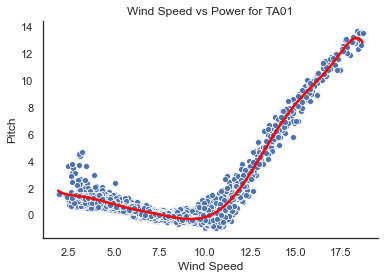

Area under the curve for TA01 :  62.18578788170754





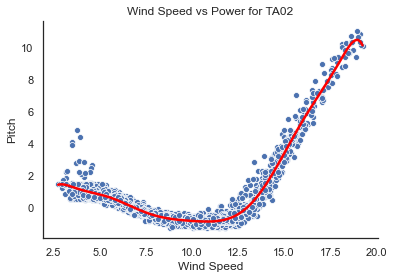

Area under the curve for TA02 :  34.136339580971224





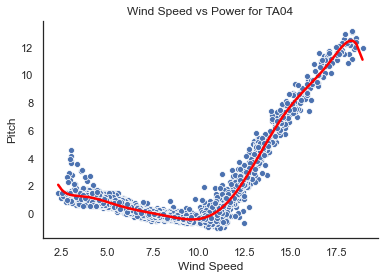

Area under the curve for TA04 :  59.40032229854487





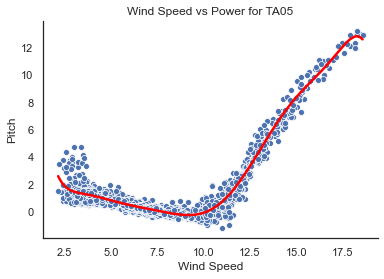

Area under the curve for TA05 :  61.65331340654881





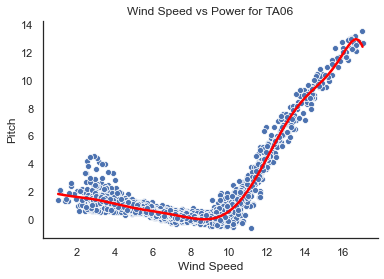

Area under the curve for TA06 :  58.56404772545477





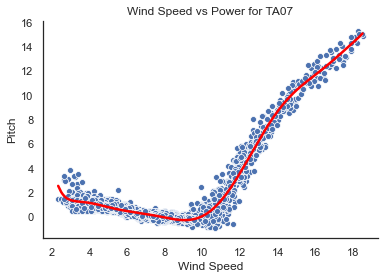

Area under the curve for TA07 :  73.79280057707803





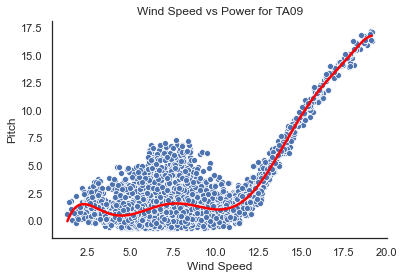

Area under the curve for TA09 :  85.17616018992629





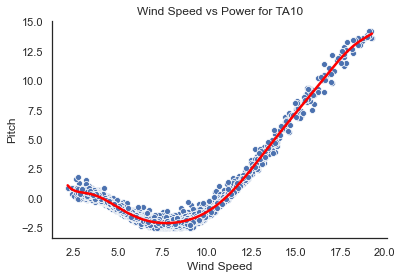

Area under the curve for TA10 :  52.68418034192658





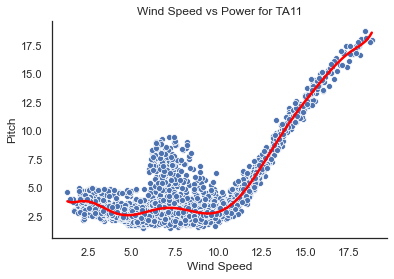

Area under the curve for TA11 :  123.62955600224713





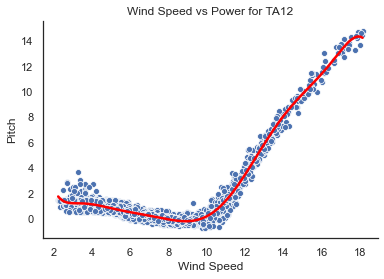

Area under the curve for TA12 :  66.82321052238157





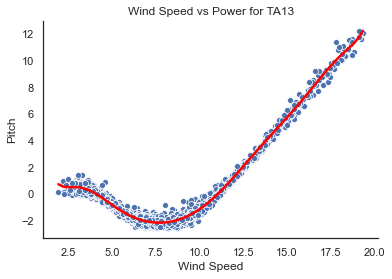

Area under the curve for TA13 :  41.49205654411788





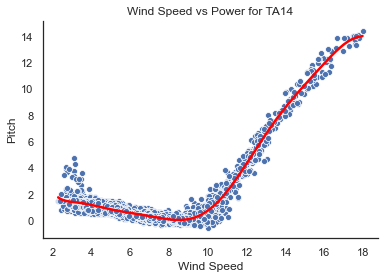

Area under the curve for TA14 :  69.78282197460263





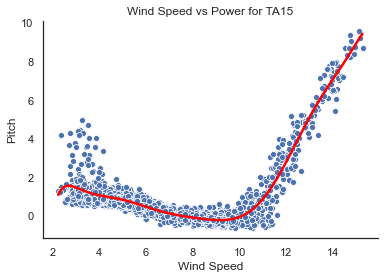

Area under the curve for TA15 :  26.679112966032775





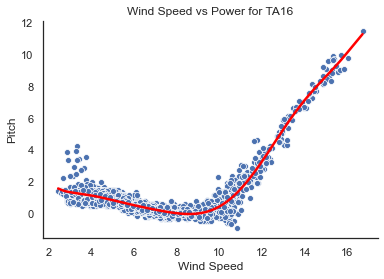

Area under the curve for TA16 :  43.14503033172265





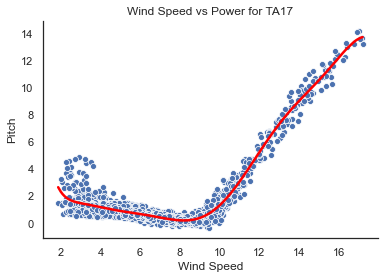

Area under the curve for TA17 :  64.62066266090673





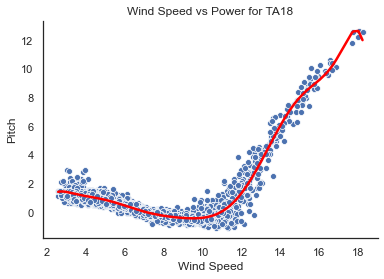

Area under the curve for TA18 :  50.93794060961893





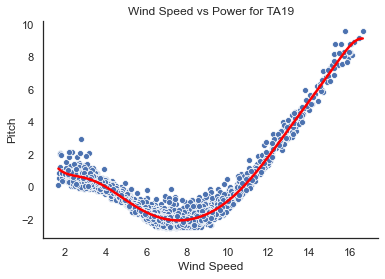

Area under the curve for TA19 :  20.32083624444938





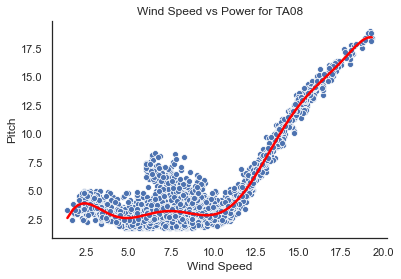

Area under the curve for TA08 :  129.12545557951563





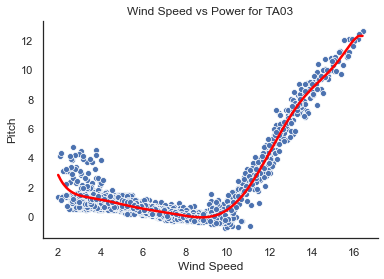

Area under the curve for TA03 :  49.05349497839498





In [10]:
# Remove rows that have more than 25 units of pitch value because they are noise
new_power_data = power_data.drop(power_data[power_data["pitch"] >= 25].index)
new_power_data = new_power_data.drop(new_power_data[(new_power_data["pitch"] >= 5) & (new_power_data["wind_speed"] <= 6)].index)

# Add turbine ids that you want here
turbine_ids = new_power_data["turbine_id"].unique()
# Different turbines should be given different hyperparameter values for outlier removal
outlier_hyperparams_for_turbines = {"TE004": (2,3),
                                   "TE005": (2,3),
                                   "TE006": (3,3),
                                   "TE007": (3,3),
                                   "TE003": (3,3),
                                   "TG005": (12,3),
                                   "TG006": (8,3),
                                   "TL002": (6,2),
                                   "TL003": (12,3),
                                   "TL004": (6,2)}
# Save the regression based predictions into an array
turbine_pred_pitch = [list() for i in range(len(turbine_ids))]
turbine_auc = list()
turbine_dict = dict()

for index, turbine_id in enumerate(turbine_ids):
    # Get power values
    pitch = new_power_data[new_power_data["turbine_id"] == turbine_id]["pitch"].values
    # Get corresponding wind speed values
    wind_speed = new_power_data[new_power_data["turbine_id"] == turbine_id]["wind_speed"].values
    
    # Set default hyper-parameters for outlier removal. These will be applied in case no parameters have defined manually
    default_max_distance, default_min_neighbors = 1, 8
    # Get the manually defined hyper-parameters
    hyper_params = outlier_hyperparams_for_turbines.get(turbine_id, [default_max_distance, default_min_neighbors])
    # Set the parameters
    max_distance, min_neighbors = hyper_params[0], hyper_params[1]
    # Applyh outlier removal
    wind_speed, pitch = outlier_removal(wind_speed, pitch, max_distance, min_neighbors)
    
    # Create training data
    X_train = convert_to_dataset(wind_speed, poly=10)
    # Test data is simply the training data but in sorted order
    X_test = convert_to_dataset(np.sort(wind_speed), poly=10)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Simple linear regression is applied
    model = LinearRegression()
    model.fit(X_train, pitch)
    preds = model.predict(X_test)

    # Plot wind_speed vs power
    sns.set(style="white")
    sns.scatterplot(wind_speed, pitch)
    sns.lineplot(np.sort(wind_speed), preds, color='red', linewidth=2.5)
    plt.xlabel("Wind Speed")
    plt.ylabel("Pitch")
    plt.title("Wind Speed vs Power for "+turbine_id)
    sns.despine()
    plt.show()

    # Calculate Area Under the Curve (AUC). Larger values mean better power generation
    area_under_curve = auc(np.sort(wind_speed), preds)
    print("Area under the curve for", turbine_id,": ", area_under_curve)
    print("\n\n")
    
    turbine_pred_pitch[index].extend(preds)
    turbine_auc.append(area_under_curve)
    turbine_dict[turbine_id] = index

### 2.2 Check which auc's (turbines) are significantly different. Then group and rank them

In [11]:
i = 0
all_groups, new_turbine_ids = list(), copy.deepcopy(turbine_ids)
flag = False
while True:
    # Find the next turbine which is yet to be selected for grouping
    while True:
        if i >= len(new_turbine_ids):
            flag = True
            break
        if new_turbine_ids[i] == " ":
            i+=1
        else:
            new_group = [new_turbine_ids[i]]
            new_turbine_ids[i] = " "
            break
    if flag:
        break
    # Take this turbine and find all turbines that it is similar to
    for j in range(i+1, len(new_turbine_ids)):
        if new_turbine_ids[j]!= " " and mannwhitneyu(turbine_pred_pitch[i], turbine_pred_pitch[j])[1] > 0.1:
            new_group.append(new_turbine_ids[j])
            new_turbine_ids[j] = " "
    group_pitch = np.mean([turbine_auc[turbine_dict[turbine_id]] for turbine_id in new_group])
    all_groups.append([new_group, group_pitch])
    
# Rank the groups according to their average AUC
all_groups = [[i, j] for i, j in sorted(all_groups, key = lambda x: x[1], reverse=True)]

        
for i in all_groups:
    print(i[0], "\t", i[1])

['TA08'] 	 129.12545557951563
['TA11'] 	 123.62955600224713
['TA09'] 	 85.17616018992629
['TA14'] 	 69.78282197460263
['TA05', 'TA07'] 	 67.72305699181342
['TA12'] 	 66.82321052238157
['TA17'] 	 64.62066266090673
['TA04'] 	 59.40032229854487
['TA06'] 	 58.56404772545477
['TA10'] 	 52.68418034192658
['TA18'] 	 50.93794060961893
['TA03'] 	 49.05349497839498
['TA01', 'TA15'] 	 44.43245042387016
['TA16'] 	 43.14503033172265
['TA13'] 	 41.49205654411788
['TA02'] 	 34.136339580971224
['TA19'] 	 20.32083624444938
